In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils
from Utils import plot_utils
from Utils import common_functions
importlib.reload(plot_utils)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [2]:
clinical_ph = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")['ph']
clinical_ph

1001    7.14
1002    7.00
1003    7.20
1004    7.30
1005    7.30
        ... 
2042    7.33
2043    7.08
2044    7.02
2045    7.03
2046    7.01
Name: ph, Length: 552, dtype: float64

In [3]:
# .apply(lambda x: 0 if x >= 7.2 else 1)
# >= 7.2 normal // < 7.2 patologico
clinical_ph_0 = clinical_ph[clinical_ph >= 7.2]
clinical_ph_1 = clinical_ph[clinical_ph < 7.2]

clinical_ph_0.shape, clinical_ph_1.shape

((375,), (177,))

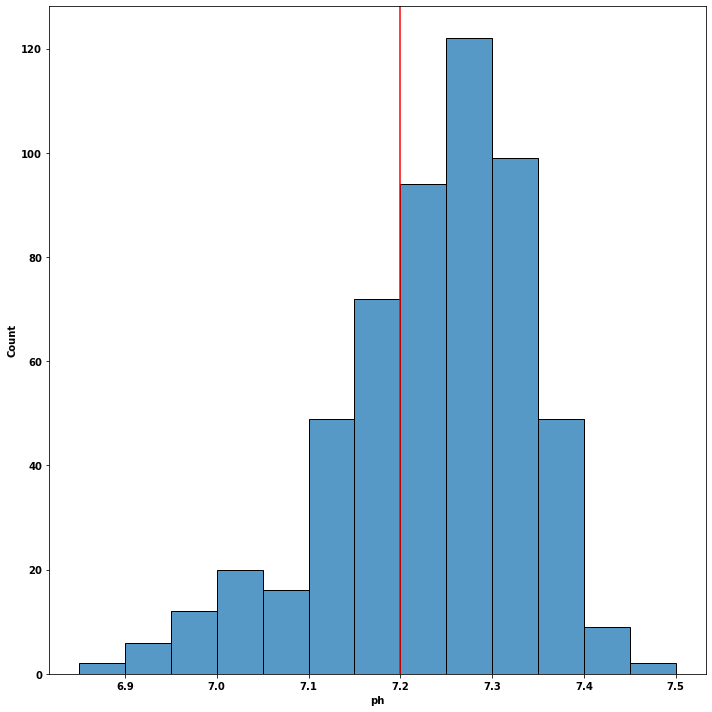

In [4]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(7.2, color='red')
fig.tight_layout()

In [5]:
prop_0 = clinical_ph_0.shape[0] / clinical_ph.shape[0]
prop_1 = clinical_ph_1.shape[0] / clinical_ph.shape[0]

prop_0, prop_1

(0.6793478260869565, 0.32065217391304346)

(7.18, 7.22)

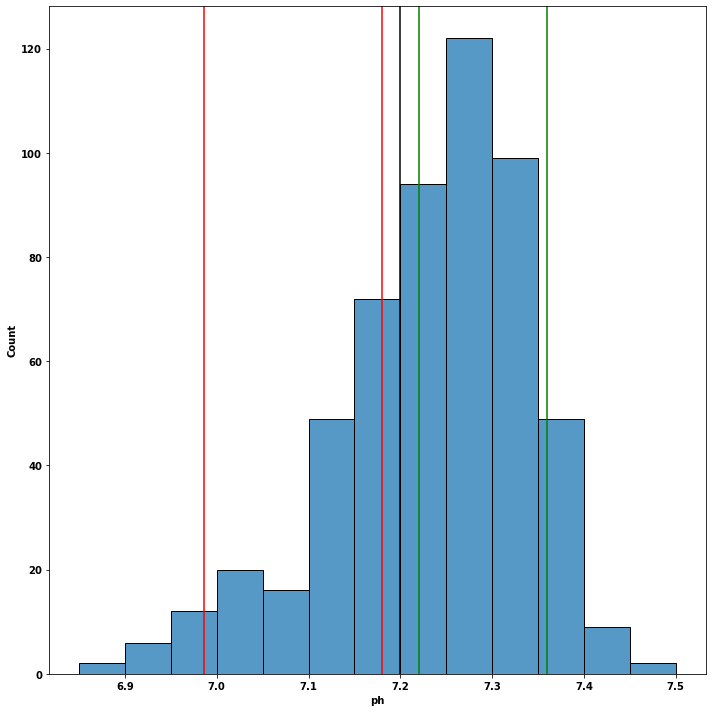

In [6]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(clinical_ph_0.quantile(0.1), color='green')
ax.axvline(clinical_ph_0.quantile(0.9), color='green')
ax.axvline(clinical_ph_1.quantile(0.9), color='red')
ax.axvline(clinical_ph_1.quantile(0.1), color='red')
ax.axvline(7.2, color='black')
fig.tight_layout()

clinical_ph_1.quantile(0.9), clinical_ph_0.quantile(0.1)

In [7]:
removed = clinical_ph[(7.18 <= clinical_ph) & (clinical_ph <= 7.22)]
removed.shape[0] / clinical_ph.shape[0]

0.1539855072463768

In [8]:
before_dismissed = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
                    1327, 1451, 1477, 1482, 2003]
removed_index = removed.index.to_list()
removed_index = set(removed_index).union(set(before_dismissed))
removed_index = np.array(list(removed_index))
removed_index.shape

(99,)

In [9]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

In [10]:
clean_fhr = fhr.drop(removed_index)
clean_uc = uc.drop(removed_index)
y_clean = y.drop(removed_index)
clean_fhr.shape, clean_uc.shape, y_clean.shape

((453, 21620), (453, 21620), (453,))

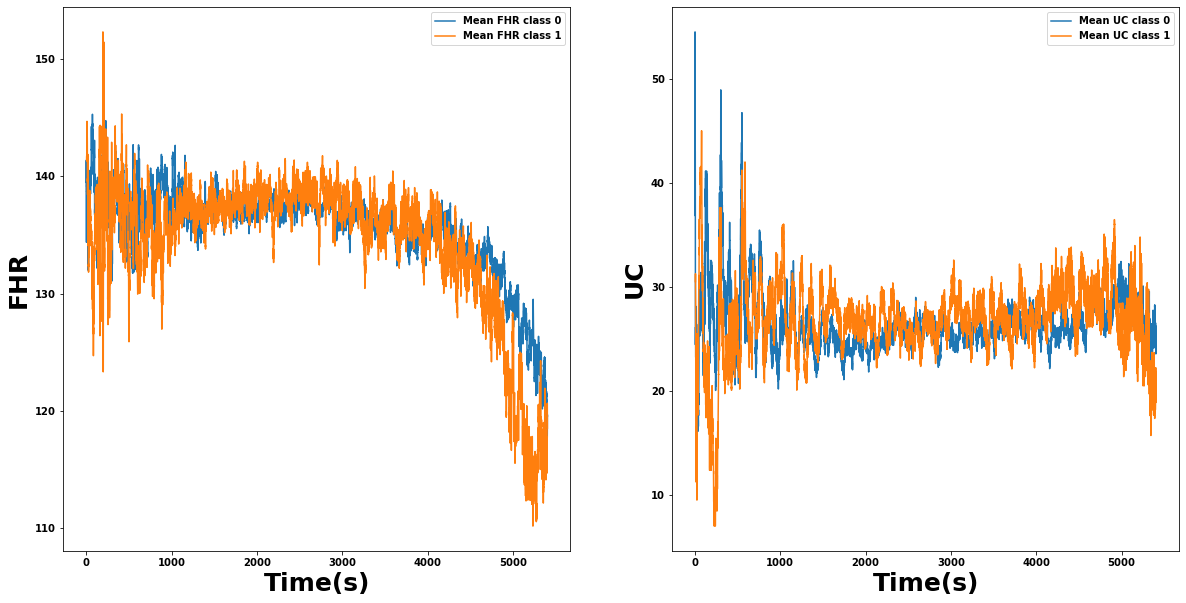

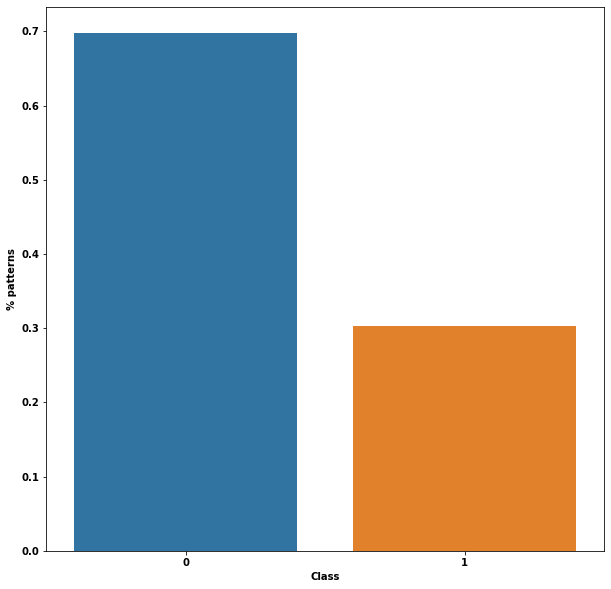

In [11]:
plot_utils.plot_fhr_uc(clean_fhr, clean_uc, y_clean)
plot_utils.plot_class_proportion(y_clean)

In [12]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 3000) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/453 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1001,-0.143611,-0.143392,-0.143133,-0.143069,-0.143331,-0.143864,-0.144430,-0.144705,-0.145320,-0.145763,...,-0.071019,-0.072023,-0.073669,-0.075269,-0.076692,-0.077778,-0.078876,-0.079965,-0.081177,-0.082298
1002,0.051316,0.048979,0.046630,0.043732,0.040791,0.037558,0.034548,0.032020,0.030232,0.027842,...,0.075747,0.077366,0.078866,0.080367,0.081703,0.082672,0.083245,0.083386,0.082942,0.081982
1004,0.011775,0.010709,0.009421,0.007845,0.006370,0.005518,0.005287,0.004886,0.004552,0.004915,...,-0.135158,-0.134690,-0.133797,-0.133298,-0.132531,-0.131928,-0.131086,-0.130169,-0.129447,-0.128523
1005,-0.126280,-0.126069,-0.125784,-0.125867,-0.125825,-0.125499,-0.124934,-0.124543,-0.123750,-0.123181,...,-0.006627,-0.006341,-0.005711,-0.005226,-0.005344,-0.005489,-0.005640,-0.005584,-0.005516,-0.005679
1006,0.011752,0.015884,0.015719,0.016986,0.017949,0.018932,0.020794,0.020823,0.020344,0.015404,...,0.093530,0.094747,0.097826,0.101300,0.103749,0.106475,0.107071,0.105926,0.104626,0.105933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,-0.079467,-0.077935,-0.076384,-0.074798,-0.073322,-0.071966,-0.070564,-0.069252,-0.067818,-0.066883,...,-0.209855,-0.210246,-0.210503,-0.211309,-0.211807,-0.212266,-0.213027,-0.213783,-0.214986,-0.215639
2043,0.007374,0.006142,0.004517,0.002829,0.001037,-0.000626,-0.001970,-0.002984,-0.004611,-0.006215,...,-0.178921,-0.178776,-0.178597,-0.178450,-0.177884,-0.177448,-0.176855,-0.176449,-0.175893,-0.175490
2044,0.009746,0.009735,0.009070,0.008440,0.007824,0.007105,0.006719,0.005917,0.005915,0.006205,...,0.157561,0.158602,0.159348,0.160350,0.160821,0.161080,0.161083,0.160907,0.161083,0.161616
2045,0.033712,0.032558,0.030776,0.028386,0.025563,0.022178,0.018981,0.015537,0.012145,0.008431,...,0.157266,0.157449,0.157424,0.157303,0.157174,0.156988,0.156626,0.156216,0.155449,0.154729


In [13]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [14]:
cc_df = cc_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cc_df.shape, y_clean.shape

((453, 2399), (453,))

In [15]:
cdcor_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cdcor_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 3000)
        for lag in lags
    )
cdcor_df = pd.DataFrame(cdcor_data).T
cdcor_df.columns = lags
cdcor_df

  0%|          | 0/453 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1001,0.192948,0.192632,0.192154,0.191921,0.191809,0.191764,0.191722,0.191468,0.191558,0.191530,...,0.158082,0.158771,0.159855,0.160587,0.161317,0.161952,0.162629,0.163300,0.163993,0.164692
1002,0.100468,0.100972,0.101555,0.102130,0.102827,0.103549,0.104658,0.106062,0.107638,0.108457,...,0.139922,0.140125,0.140254,0.140413,0.140592,0.140582,0.140679,0.140510,0.139915,0.138960
1004,0.113373,0.113774,0.114102,0.114211,0.114659,0.115114,0.115175,0.115475,0.115971,0.116520,...,0.179583,0.179500,0.179391,0.179345,0.179100,0.178829,0.178438,0.178080,0.177652,0.177054
1005,0.242651,0.242835,0.243133,0.243841,0.244312,0.244256,0.244066,0.244242,0.243950,0.244043,...,0.157983,0.157987,0.157851,0.157704,0.157901,0.158041,0.158127,0.157934,0.157745,0.157743
1006,0.146380,0.144018,0.143483,0.142895,0.143252,0.144087,0.144774,0.144527,0.144081,0.143624,...,0.133232,0.133630,0.134726,0.135021,0.135974,0.137754,0.138588,0.139049,0.139179,0.139841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,0.131818,0.131582,0.131271,0.130819,0.130369,0.130064,0.129818,0.129748,0.129833,0.130096,...,0.237502,0.238429,0.239330,0.240515,0.241493,0.242233,0.243234,0.244157,0.245192,0.246006
2043,0.110304,0.110701,0.111004,0.110785,0.110925,0.111393,0.112049,0.112842,0.113590,0.114025,...,0.290978,0.290896,0.290442,0.289885,0.289018,0.288247,0.287252,0.286135,0.284944,0.283996
2044,0.146177,0.146335,0.146558,0.146824,0.146973,0.147125,0.147307,0.147527,0.147622,0.147567,...,0.224921,0.224977,0.224839,0.224642,0.224270,0.223962,0.223642,0.223450,0.223216,0.222841
2045,0.073986,0.073968,0.073926,0.073650,0.073883,0.073773,0.073980,0.074162,0.074389,0.074561,...,0.129845,0.129806,0.129638,0.129366,0.129123,0.128840,0.128408,0.127970,0.127320,0.126717


In [18]:
bad_idx = cdcor_df.index[cdcor_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

Int64Index([], dtype='int64')

In [19]:
cdcor_df = cdcor_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cdcor_df.shape, y_clean.shape

((453, 2399), (453,))

((453, 2399), (453,))

In [20]:
fft_data = dict()
freqs = t_utils.get_freqs(fhr.shape[-1])

for idx_fhr, fhr_row in tqdm(clean_fhr.copy().iterrows(), total=len(clean_fhr)):
    fhr_signal = fhr_row.values

    fft_data[idx_fhr] = t_utils.nan_save_fft(fhr_signal, freqs)

  0%|          | 0/453 [00:00<?, ?it/s]

In [21]:
fft_df = pd.DataFrame(fft_data).T
fft_df.columns = freqs
fft_df = fft_df.loc[:, freqs <= 0.1]
fft_df = fft_df.iloc[:, 1:]
freqs = np.array(freqs)[freqs <= 0.1][1:]
fft_df

,0.000185,0.000370,0.000555,0.000740,0.000925,0.001110,0.001295,0.001480,0.001665,0.001850,...,0.098242,0.098427,0.098612,0.098797,0.098982,0.099167,0.099352,0.099537,0.099722,0.099907
1001,6.952497e+05,4.468181e+05,428764.789133,131342.818035,63500.016257,188688.579360,162030.800120,93410.187650,23648.215375,61318.704643,...,8169.303814,12606.214789,16516.252043,21757.672538,2149.114559,23723.087400,16773.537565,21729.025938,37413.874209,26112.753157
1002,7.593216e+05,4.234167e+05,229900.867219,367301.819231,317234.221504,59788.970345,163738.408530,22425.220599,29525.939103,154843.283789,...,19987.874148,17462.673806,14690.647909,23128.750009,19142.980988,12469.157302,7374.787178,12378.828219,12153.071679,17533.756517
1004,8.480775e+05,6.447865e+05,283623.313506,86750.269146,138050.781488,126548.681553,141234.326064,71740.536818,50350.172330,78410.132774,...,5529.865013,3223.492709,2735.773744,2317.109110,3376.993304,1431.849621,3739.614016,3117.085007,938.478442,4249.392013
1005,9.892601e+05,5.393654e+05,80580.461556,122561.687447,216241.769749,185922.620633,58610.383669,107677.337489,187617.522019,63404.422816,...,23445.906317,18857.814708,6254.031696,19501.097850,6394.706805,15407.872449,5895.693264,21997.771557,8787.444150,18517.452077
1006,4.834163e+05,1.374470e+06,290356.427143,453006.818055,407102.491515,106538.466408,136141.123892,191817.312525,157409.717464,175877.783795,...,23865.410816,20216.652548,17780.665443,9526.864181,6049.382204,8238.441896,10245.902187,16277.270298,18315.970316,17123.789017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,1.113381e+06,5.833392e+05,34863.576885,304637.367072,238602.887594,38188.515685,176367.628728,151442.274934,43097.481274,126291.141105,...,7780.356365,2893.632444,1620.945887,3334.664223,3285.460752,4247.097505,3438.509811,6947.748183,9955.652788,10631.677496
2043,6.354950e+05,5.508237e+05,418518.851728,260158.286454,309211.328105,181059.616083,121957.114262,187818.661390,37404.570670,253064.639584,...,14337.236895,4607.442143,9173.857815,8823.195893,15249.646648,11056.069116,1672.288258,4081.077702,12735.470130,9403.181577
2044,1.353436e+06,7.243038e+05,57644.239917,363790.725783,290057.641381,33268.903643,215035.739114,147605.482310,30046.118843,131281.026743,...,3591.598836,2793.073099,2734.294538,2598.577669,4482.027638,361.447820,2296.427635,6908.955743,2428.634050,8209.963495
2045,1.128119e+06,4.759690e+05,286972.840062,508415.058278,408128.374583,226329.990086,201665.375829,58677.725568,156770.694236,114602.439282,...,4061.860137,3853.740527,3740.732802,5969.087631,6014.318257,7284.575663,1631.543251,1688.587120,5800.980207,3239.306574


In [22]:
cc_df.to_csv(f"{paths.CC_DATA_PATH}/easy_cc_dataset.csv")
cc_df['patologico'] = y_clean
X = cc_df.iloc[:, :-1]
X.to_pickle(f"{paths.CC_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.CC_DATA_PATH}/easy_y.pickle")

In [23]:
cdcor_df.to_csv(f"{paths.CDCOR_DATA_PATH}/easy_cc_dataset.csv")
cdcor_df['patologico'] = y_clean
X = cdcor_df.iloc[:, :-1]
X.to_pickle(f"{paths.CDCOR_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.CDCOR_DATA_PATH}/easy_y.pickle")

In [24]:
fft_df.to_csv(f"{paths.FFT_DATA_PATH}easy_cc_dataset.csv")
fft_df['patologico'] = y_clean
X = fft_df.iloc[:, :-1]
X.to_pickle(f"{paths.FFT_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.FFT_DATA_PATH}/easy_y.pickle")